<a href="https://colab.research.google.com/github/rodriguezhh/IA_SIDIEN/blob/main/Inteligencia_Artificial_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DIAGNÓSTICO DE ENFERMEDADES EN LA HOJA DEL TOMATE MEDIANTE UN SISTEMA EMBEBIDO USANDO INTELIGENCIA ARTIFICIAL E IMÁGENES.
## Trabajo De Grado

## **Acceder al drive**

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


##**Importación de librerías**

In [2]:
#librerias para el modelo
import tensorflow as tf
import keras
from keras import models, layers
import matplotlib.pyplot as plt
import numpy as np 
from keras.applications import MobileNetV2

# librerias para el dataset
from keras.preprocessing.image import ImageDataGenerator

#librerias para las métricas 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## **Base De Datos**
La base de datos consta de tres enfermedades de la hoja de la planta del tomate y la hoja sana de la misma. La información, en este caso las imágenes, tiene una dimensión de 256 x 256 píxeles.

Guardamos la información previamente separada en la variables train, validation y test.

In [3]:
# Definimos el tamaño de las imágenes y el tamaño del lote
image_size = 224 
batch_size = 32

# Creamos un generador de datos de imágenes para el entrenamiento con el objeto ImageDataGenerator
train_generator = ImageDataGenerator()

# Cargamos las imágenes de entrenamiento desde el directorio especificado y las transformamos utilizando el generador de datos
train = train_generator.flow_from_directory(
    '/content/drive/MyDrive/Tesis/Dataset/60_20/train', # Ruta al directorio de entrenamiento
    target_size = (image_size, image_size), # Definimos el tamaño al que se redimensionarán todas las imágenes
    batch_size = batch_size, # Definimos el tamaño del lote
    shuffle = True, # Definimos si se barajarán aleatoriamente las imágenes en cada lote
    class_mode = 'categorical' # Definimos el modo de clasificación categórica
)

# Cargamos las imágenes de validación desde el directorio especificado y las transformamos utilizando el generador de datos
validation = train_generator.flow_from_directory( 
    '/content/drive/MyDrive/Tesis/Dataset/60_20/val', # Ruta al directorio de validación
    target_size = (image_size, image_size), # Definimos el tamaño al que se redimensionarán todas las imágenes
    shuffle = False, # Definimos si se barajarán aleatoriamente las imágenes en cada lote
    batch_size = batch_size, # Definimos el tamaño del lote
    class_mode = 'categorical' # Definimos el modo de clasificación categórica
)

# Creamos otro generador de datos de imágenes para las imágenes de prueba
test_generator = ImageDataGenerator()

# Cargamos las imágenes de prueba desde el directorio especificado y las transformamos utilizando el generador de datos
test = test_generator.flow_from_directory(
    '/content/drive/MyDrive/Tesis/Dataset/60_20/test', # Ruta al directorio de prueba
    target_size = (image_size, image_size), # Definimos el tamaño al que se redimensionarán todas las imágenes
    shuffle = False, # Definimos si se barajarán aleatoriamente las imágenes en cada lote
    batch_size = batch_size, # Definimos el tamaño del lote
    class_mode='categorical' # Definimos el modo de clasificación categórica
)


Found 7398 images belonging to 4 classes.
Found 1224 images belonging to 4 classes.
Found 1232 images belonging to 4 classes.


Las etiquetas de las imagenes son las siguietes:

In [4]:
train.class_indices

{'Tomato_Early_blight': 0,
 'Tomato_Late_blight': 1,
 'Tomato_healthy': 2,
 'Tomato_mosaic_virus': 3}

## **Modelo**

In [5]:
# Definir la cantidad de canales de la imagen
rgb = 3

# Crear un modelo utilizando la arquitectura ResNet50 pre-entrenada en ImageNet
model_mobilnetv2 = MobileNetV2(
    weights="imagenet",  # Usar los pesos pre-entrenados en ImageNet
    include_top=False,  # No incluir la capa fully-connected de ImageNet
    input_shape=(image_size, image_size, rgb)  # Definir el tamaño de las imágenes de entrada
)

9406464/9406464 [==============================] - 1s 0us/step


Model: "modelo_MobileNetV2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                

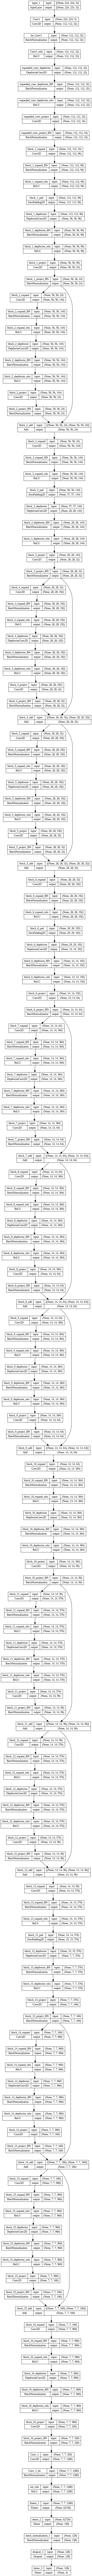

In [7]:
# Asignar la salida de la última capa del modelo MobileNetV2
x = model_mobilnetv2.output

# Capa de aplanamiento
x = layers.Flatten()(x)

# Capa densa
x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.BatchNormalization()(x)

# Capa de Dropout con 20% de probabilidad 
x = layers.Dropout(0.2)(x)

# Capa de salida con activación softmax
outputs = layers.Dense(4, activation="softmax", kernel_initializer='glorot_uniform')(x)

model = keras.Model(inputs=model_mobilnetv2.input, outputs=outputs, name="modelo_MobileNetV2")

# Establecer todas las capas del modelo como no entrenables, excepto las últimas cinco capas
for layer in model.layers[:-5]:
	layer.trainable = False

# Resumen del modelo
model.summary()

# Grafica la estructura del modelo
keras.utils.plot_model(model, "modelo_MobileNetV2.png", show_shapes=True)

## **Método Compile de Keras**
Definiendo el optimizador, la función de perdida y la métrica.

1.   Optimizadior: Adam. 
2.   Función de perdida: categorical_crossentropy. Porque previamente se definieron las etiquetas como "one-hot".
3.   Métrica: Accuracy. Se escoge la exactitud porque es la varible estandar de interes de un modelo. 



In [8]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001),
 loss= keras.losses.CategoricalCrossentropy(),
 metrics=["accuracy"])

## **Callbacks**


1.   EarlyStopping: Nos permite detener el entrenamiento cuando la variable que se monitorea deja de mejorar. 
2.   ReduceLROnPlateau: Reduce el "learning rate" cuando la variable que se monitorea deja de mejorar. 



In [9]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # La métrica que se va a monitorear para detener el entrenamiento
    patience=5,                    # El número de épocas que esperará antes de detener el entrenamiento
    verbose=1,                     # El nivel de detalle que se mostrará durante el entrenamiento
    restore_best_weights=True      # Si se deben restaurar los pesos del modelo a la mejor época durante el entrenamiento
)

In [10]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',           # La métrica que se va a monitorear para reducir la tasa de aprendizaje
    factor=0.2,                   # Factor de reducción de la tasa de aprendizaje
    patience=2,                   # El número de épocas que esperará antes de reducir la tasa de aprendizaje
    verbose=1                     # El nivel de detalle que se mostrará durante el entrenamiento
)

## **Entrenamiento del modelo**

In [11]:
history = model.fit(
    train,
    batch_size = batch_size,
    validation_data = validation, 
    epochs = 9000000,
    callbacks = [earlystopping, reduce_lr],
    )

Epoch 1/9000000
232/232 [==============================] - 5176s 22s/step - loss: 0.6263 - accuracy: 0.7594 - val_loss: 0.6043 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 2/9000000
232/232 [==============================] - 37s 157ms/step - loss: 0.3219 - accuracy: 0.8785 - val_loss: 0.4440 - val_accuracy: 0.8342 - lr: 0.0010
Epoch 3/9000000
232/232 [==============================] - 37s 161ms/step - loss: 0.2297 - accuracy: 0.9144 - val_loss: 0.7363 - val_accuracy: 0.7729 - lr: 0.0010
Epoch 4/9000000
232/232 [==============================] - ETA: 0s - loss: 0.1430 - accuracy: 0.9490
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
232/232 [==============================] - 37s 160ms/step - loss: 0.1430 - accuracy: 0.9490 - val_loss: 0.8925 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 5/9000000
232/232 [==============================] - 37s 158ms/step - loss: 0.0696 - accuracy: 0.9811 - val_loss: 0.5434 - val_accuracy: 0.8284 - lr: 2.0000e-04
Epoch 6/9000000
232

## **Evaluando el modelo**

In [12]:
scores = model.evaluate(test)
print(scores)

39/39 [==============================] - 788s 21s/step - loss: 0.4401 - accuracy: 0.8336
[0.44013774394989014, 0.8336039185523987]


## **Gráficas de 'Accuracy' y 'Loss' del modelo**

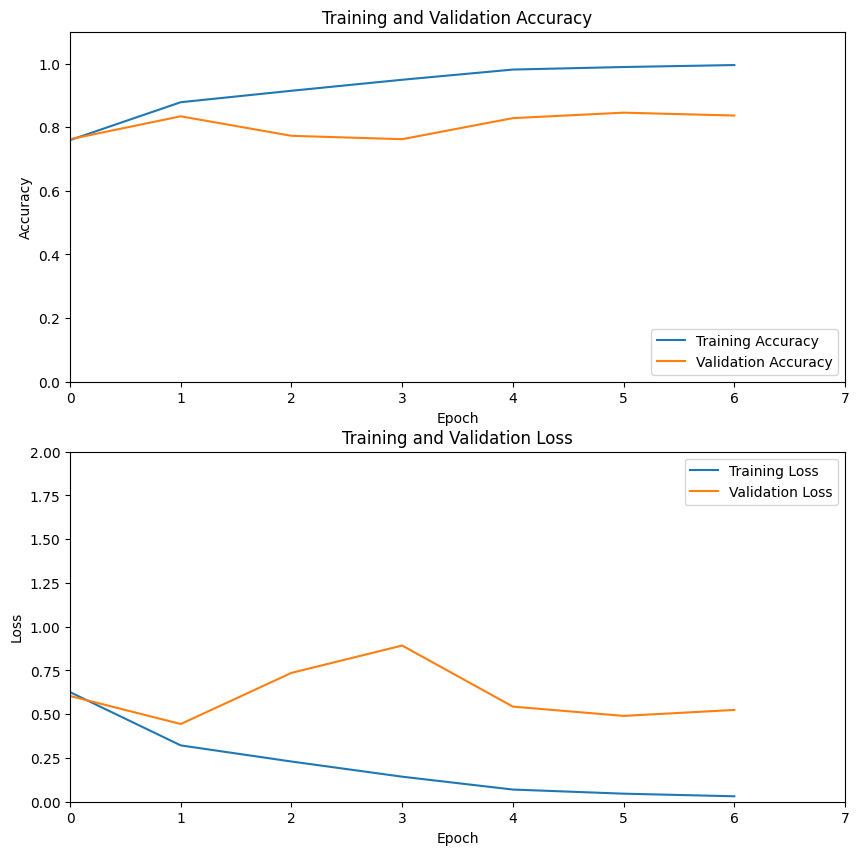

In [17]:
# Se crea una figura con dos imagenes
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

# Se grafica la precisión de entrenamiento y validación
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Se añaden nombres a los ejes y se agrega una leyenda y un título a la imagen
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlim([0, 7])  # Establecer los límites del eje x
plt.ylim([0, 1.1])  # Establecer los límites del eje y

# Se crea la segunda imagen
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Se añaden nombres a los ejes y se agrega una leyenda y un título a la imagen
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlim([0, 7])  # Establecer los límites del eje x
plt.ylim([0, 2])  # Establecer los límites del eje y


# Se muestran los gráficos
plt.show()

## **Matriz de confusión**

39/39 [==============================] - 5s 120ms/step


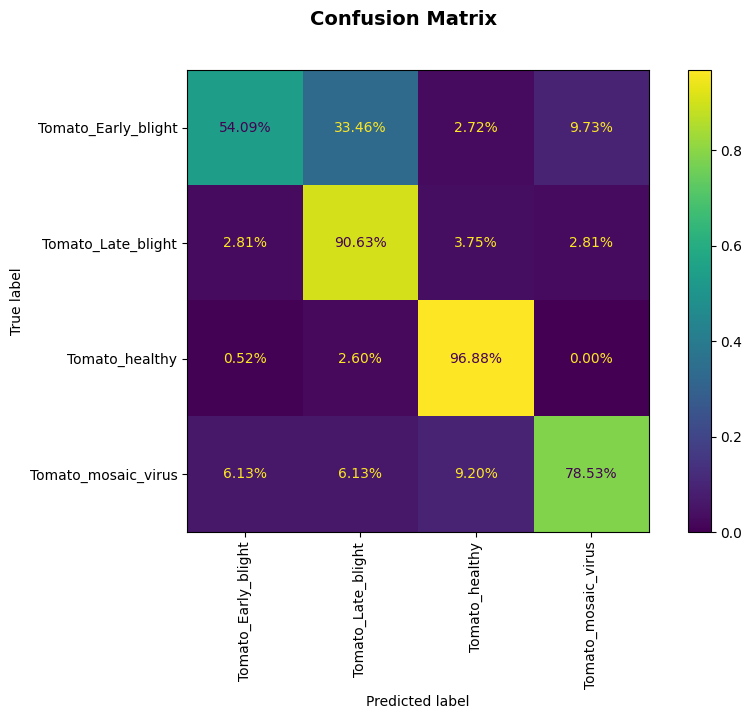

In [14]:
# Generar predicciones en el conjunto de prueba
predictions = model.predict(test)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las clases verdaderas y las etiquetas de las clases
true_classes = test.classes
class_labels = list(test.class_indices.keys())    

# Calcular la matriz de confusión normalizada
cm = confusion_matrix(
    y_true=true_classes,
    y_pred=predicted_classes,
    normalize='true')

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(10, 6))
disp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical", values_format=".2%")

# Configurar el título del gráfico
fig.suptitle("Confusion Matrix", fontsize=14, fontweight='bold')

# Mostrar el gráfico
plt.show()

## **Métricas**

In [15]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

                     precision    recall  f1-score   support

Tomato_Early_blight       0.85      0.54      0.66       257
 Tomato_Late_blight       0.78      0.91      0.84       427
     Tomato_healthy       0.91      0.97      0.94       385
Tomato_mosaic_virus       0.78      0.79      0.78       163

           accuracy                           0.83      1232
          macro avg       0.83      0.80      0.81      1232
       weighted avg       0.84      0.83      0.83      1232



## **Guardando el modelo**

In [18]:
model.save('modelo_MobileNetV2.h5')